<a href="https://colab.research.google.com/github/Hit07/ML-DL-Torch/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution Neural Network

- Getting a vision dataset to work with using torchvision.datasets
- Architecture of a convolutional neural network (CNN) with PyTorch
- An end-to-end multi-class image classification problem
- Steps in modelling with CNNs in PyTorch
- Creating a CNN model with PyTorch
- Picking a loss and optimizer
- Training a model a model
- Evaluating a model


## 0. Computer vision libaries in PyTorch
*   [**torchvision**](https://www.learnpytorch.io/03_pytorch_computer_vision/) - base
domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer
vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images)
to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

# Import Statemnents

In [2]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('skipped')
else:
  print(f'Downloaded')
  r = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  r.raise_for_status
  with open('helper_functions.py','wb') as file:
    file.write(r.content)

Downloaded


In [3]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms # Converting images to tensors
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from helper_functions import accuracy_fn
from timeit import default_timer as timer



# Getting data

In [4]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

100%|██████████| 26421880/26421880 [00:01<00:00, 16673393.96it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 299723.71it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5581425.33it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12178385.22it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



# Data Exploration

In [5]:
len(train_data),len(test_data)

(60000, 10000)

In [6]:
image,label = train_data[2]

class_name = train_data.classes
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx,train_data.targets

({'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9},
 tensor([9, 0, 0,  ..., 3, 0, 5]))

In [9]:
image.shape,class_name[label]

(torch.Size([1, 28, 28]), 'T-shirt/top')

## Visulize the data


Text(0.5, 1.0, 'Ankle boot')

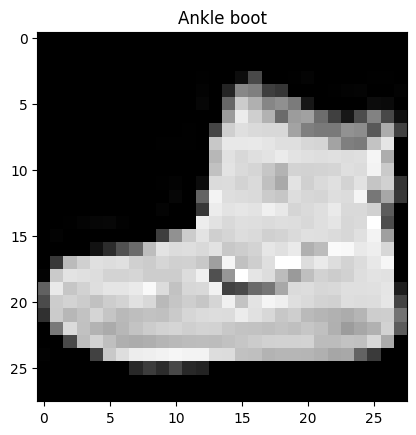

In [10]:
image,label = train_data[0]
plt.imshow(image.squeeze(),cmap='gray')
plt.title(class_name[label])

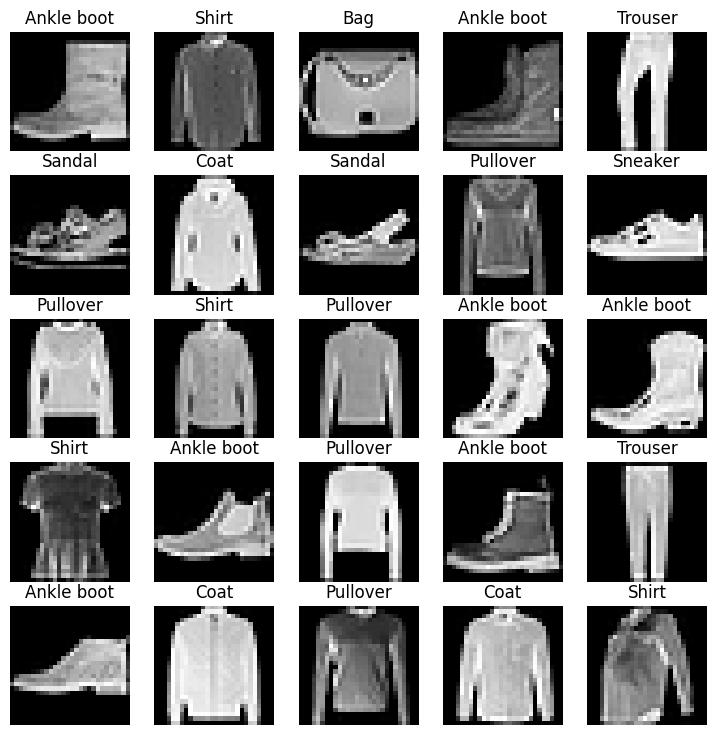

In [11]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols = 5,5
for i in range(1,rows*cols+1):
  random_idx = torch.randint(0,len(train_data),size=[1]).item()
  img,label = train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap='gray')
  plt.title(class_name[label])
  plt.axis(False)

## Prepare DataLoader
Right now, our data is in the form of PyTorch Datasets.
DataLoader turns our dataset into a Python iterable.
More specifically, we want to turn our data into batches (or mini-batches) •
Why would we do this?
1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32) •
2. It gives our neural network more chances to update its gradients per epoch.

In [12]:
# Creating batches of 32 samples  train(1875 batches) and test(313)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size = 32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size = 32,
                              shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b9b87065510>,
 <torch.utils.data.dataloader.DataLoader at 0x7b9b87050580>)

In [13]:
train_features_batch,train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 1, label size: torch.Size([])


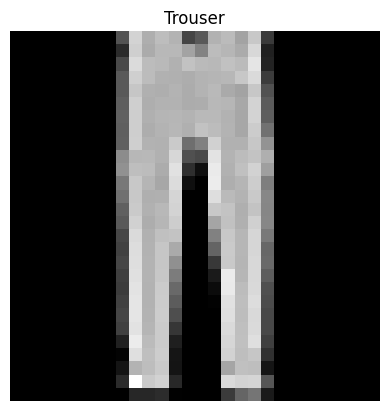

In [14]:
torch.manual_seed(42)
random_indx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,label = train_features_batch[random_indx],train_labels_batch[random_indx]
plt.imshow(img.squeeze(),cmap='gray')
plt.title(class_name[label])
plt.axis (False)
print (f"Image size: {img.shape}" )
print(f"Label: {label}, label size: {label.shape}")

# Model 0: Building Model


In [15]:
flatten_model = nn.Flatten()
# Get a single sample
x = train_features_batch[0]
# Flatten the sample
output = flatten_model(x) # perform forward pass
# Print out what happened
print(f"Shape before flattening: {x.shape} →> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) →> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [16]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [17]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(nn.Flatten(),
                                     nn.Linear(in_features=input_shape,out_features=hidden_units),
                                     nn.Linear(in_features=hidden_units,out_features=output_shape))

  def forward(self,x):
    return self.layer_stack(x)


torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape=784,
                              hidden_units=10,
                              output_shape=len(train_data.classes)).to('cpu')
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [19]:
# Loss Fuction and Optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

### Create function to time our experiments

Machine learning is very experimental.
Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs

In [20]:
def print_train_time(start:float,end:float,device:torch.device=None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time: 3f} seconds")
  return total_time

In [21]:
start_time = timer()
####
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cuda" )

Train time on cuda:  0.000047 seconds


4.6748999977808126e-05

## Creating a training loop and training a model on batches of data
1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss per batch.
3. Loop through testing batches, perform testing steps, calculate the test loss per batch.
4. Print out what's happening.
5. Time it .

In [22]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
import torch
from timeit import default_timer as timer

# Set random seed for reproducibility
torch.manual_seed(42)

train_time_start_cpu = timer()

epochs = 4
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}')
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        # Forward pass
        model_0.train()
        # Calculate loss per batch
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # accumulate loss

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if batch % 400 == 0:
            print(f'Done with batch samples: {batch * len(X)}/{len(train_dataloader.dataset)}')

    train_loss /= len(train_dataloader)  # average

    # Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test).item()
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f'\nTrain loss: {train_loss:.4f} Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}')

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_cpu, end=train_time_end_on_cpu, device=str(next(model_0.parameters()).device))


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
Done with batch samples: 0/60000
Done with batch samples: 12800/60000
Done with batch samples: 25600/60000
Done with batch samples: 38400/60000
Done with batch samples: 51200/60000

Train loss: 0.5904 Test loss: 0.5095, Test acc: 82.0387
Epoch: 1
Done with batch samples: 0/60000
Done with batch samples: 12800/60000
Done with batch samples: 25600/60000
Done with batch samples: 38400/60000
Done with batch samples: 51200/60000

Train loss: 0.4763 Test loss: 0.4799, Test acc: 83.1969
Epoch: 2
Done with batch samples: 0/60000
Done with batch samples: 12800/60000
Done with batch samples: 25600/60000
Done with batch samples: 38400/60000
Done with batch samples: 51200/60000

Train loss: 0.4550 Test loss: 0.4766, Test acc: 83.4265
Epoch: 3
Done with batch samples: 0/60000
Done with batch samples: 12800/60000
Done with batch samples: 25600/60000
Done with batch samples: 38400/60000
Done with batch samples: 51200/60000

Train loss: 0.4425 Test loss: 0.4631, Test acc: 83.7460
Train time o

## Make predictions and get Model_0 results

In [23]:
torch.manual_seed(42)
def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
  ''' Return a dictionary containing the results of model predicting on data_loader.'''
  loss,acc=0,0
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      y_predic = model(X)
      loss += loss_fn(y_predic,y)
      acc += accuracy_fn(y,y_predic.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return{
      'model_name':model.__class__.__name__, # works if it is created with class
      'model_loss':f'{loss.item():.4f}',
      'model_acc': f'{acc:.2f}%'}


# Calculate model 0 results on test dataset

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': '0.4631',
 'model_acc': '83.75%'}

# Improving the Model(Change the device to run on GPU)

In [24]:
class FashionModelV1(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.layer_stack  = nn.Sequential(nn.Flatten(),
                                      nn.Linear(in_features = input_shape,out_features=hidden_units),
                                      nn.ReLU(),
                                      nn.Linear(in_features=hidden_units,out_features=output_shape),
                                      nn.ReLU())
  def forward(self,x):
    return self.layer_stack(x)

# Random_seed
torch.manual_seed(42)
#Instantiate
model_1 = FashionModelV1(input_shape=784,
                         output_shape=len(train_data.classes),
                         hidden_units=10).to('cpu')
next(model_1.parameters()).device

device(type='cpu')

In [25]:
# Loss func and Optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model_1.parameters(),lr=0.1)


In [108]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = 'cpu'):
    """Performs a training step with the model trying to learn on data_loader."""
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Move data to the same device as the model
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'\nTrain loss: {train_loss:.4f} | Train acc: {train_acc:.3f}%')


def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = 'cpu'):
    """Performs a testing step with the model evaluating on data_loader."""
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Move data to the same device as the model
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f'\nTest loss: {test_loss:.4f} | Test acc: {test_acc:.3f}%')

In [27]:
torch.manual_seed(42)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model_1.to(device)

epochs = 2
start_time = timer()

# Training loop
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}')
    train_step(model_1,
               train_dataloader,
               loss_fn,
               optimiser,
               accuracy_fn,
               device)

    # Test Loop
    test_step(model_1,
              test_dataloader,
              loss_fn,
              accuracy_fn,
              device)

end_time = timer()

total_train_time = print_train_time(start_time, end_time, str(next(model_1.parameters()).device))


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0

Train loss: 1.0920 | Train acc: 61.3433

Test loss: 0.9564 | Test acc: 64.9960
Epoch: 1

Train loss: 0.7810 | Train acc: 71.9283

Test loss: 0.7223 | Test acc: 73.9117
Train time on cpu:  22.545464 seconds


> **Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.
> Why is this?
> 1. It could be that the overhead for copying data/model to and from the GPU
outweighs the compute benefits offered by the GPU.
> 2. The hardware you're using has a better CPU in terms compute capability than
the GPU.

In [32]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results,model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

({'model_name': 'FashionModelV1',
  'model_loss': '0.7223',
  'model_acc': '73.91%'},
 {'model_name': 'FashionMNISTModelV0',
  'model_loss': '0.4631',
  'model_acc': '83.75%'})

# Model 2: Building a Convolutional Neural Network (CNN)

[Model Build from this<---](https://poloclub.github.io/cnn-explainer/)
CNN's are also known ConvNets.
CNN's are known for their capabilities to find patterns in visual data

In [110]:
# CNN
class FashionMNISTModelV2(nn.Module):
  ''' Model architecture that replicates the TinyVGG
  model from CNN explainer website '''

  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)

    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # Imp:
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x




In [111]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_name)).to(device)


In [62]:

len(class_name)

10

In [84]:
# Example to under what to mul with the hidden_units as in_features
random_image = torch.randn(size=(1,28,28))
model_2(random_image)

torch.Size([1, 14, 14])
torch.Size([1, 7, 7])
torch.Size([1, 10])


tensor([[ 0.0391, -0.0687, -0.0183,  0.1357,  0.0960, -0.0054, -0.1344,  0.0063,
         -0.0973,  0.1162]], grad_fn=<AddmmBackward0>)

In [112]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model_2.parameters(),lr=0.1)

In [119]:
# Training and Testing

torch.manual_seed(42)
epochs = 1


start_time_v2 = timer()
for epoch in tqdm(range(epochs)):
  print(f'Epochs: {epoch}')

  train_step(model_2,train_dataloader,loss_fn,optimiser,accuracy_fn,device)
  test_step(model_2,train_dataloader,loss_fn,accuracy_fn,device)

end_time_v2 = timer()

total_time_V2 = print_train_time(start_time_v2,end_time_v2,str(next(model_2.parameters()).device))


  0%|          | 0/1 [00:00<?, ?it/s]

Epochs: 0

Train loss: 0.2825 | Train acc: 89.643%

Test loss: 0.2569 | Test acc: 90.762%
Train time on cpu:  100.315355 seconds


In [121]:
model_2_results = eval_model(model_2,
                             test_dataloader,
                             loss_fn,
                             accuracy_fn)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': '0.2975',
 'model_acc': '89.16%'}

In [122]:
import pandas as pd
comparing_model_results = pd.DataFrame([model_0_results,
                                        model_1_results,
                                        model_2_results])
comparing_model_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.4631,83.75%
1,FashionModelV1,0.7223,73.91%
2,FashionMNISTModelV2,0.2975,89.16%


In [124]:
comparing_model_results['training_time'] = [total_train_time_model_0,
                                            total_train_time,
                                            total_time_V2]

In [125]:
comparing_model_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.4631,83.75%,44.942323
1,FashionModelV1,0.7223,73.91%,22.545464
2,FashionMNISTModelV2,0.2975,89.16%,100.315355


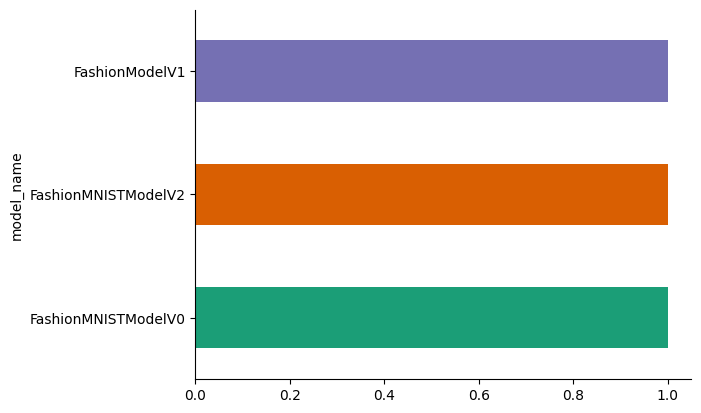

In [126]:
# @title model_name

from matplotlib import pyplot as plt
import seaborn as sns
comparing_model_results.groupby('model_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)